In [ ]:
import numpy as np
from numpy.random import randn
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

By calling `simulate` we can simulate 2000 datasets, each with 1000 samples, all following the same structural causal model:
    \begin{aligned}
    X_1 &= \epsilon_{X_1} \\
    X_2 &= \epsilon_{X_2}\\
    X_3 &= \epsilon_{X_3}\\
    X_4 &= X_5 + \epsilon_{X_4}\\
    X_5 &= X_1 + X_2 + \epsilon_{X_5}\\
    X_6 &= 0.8* X_5 + X_2 + X_3 + \epsilon_{X_6}\\
    X_7 &= 0.8 * X_6 + \epsilon_{X_7}\\
    \forall i = 1, \dots, 7 &: \epsilon_{X_i} \sim N(0,1), \\ \forall i,j = 1, \dots, 7, i \neq j&: \epsilon_{X_i} \perp\!\!\perp \epsilon_{X_j}
    \end{aligned}

In [54]:
n_samples=1000
n_datasets=2000

# Simulate data from the example structural causal model given a seed (for reproducibility):
def simulate(seed):   
    np.random.default_rng=seed
    x1 = randn(n_samples)
    x2 = randn(n_samples)
    x3 = randn(n_samples)
    x5 = x1 + x2 + randn(n_samples)
    x4 = x5 + randn(n_samples)
    x6 = 0.8*x5 + x2 + x3 + randn(n_samples)
    x7 = 0.8 * x6 + randn(n_samples)
    return pd.DataFrame({ "x1": x1, "x2": x2, "x3": x3,"x4": x4, "x5":x5, "x6":x6, "x7":x7})

dfs = []
for i in range(1,n_datasets+1):
    dfs.append(simulate(i))

All these datasets are sampled from the same distribution, e.g. we can visualize $P(X_5)$ and $P(X_7)$ and see that it is approximately the same:

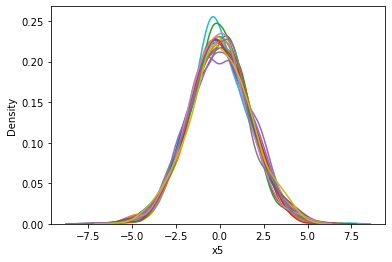

In [55]:
# Plotting 20 datasets (otherwise it's too slow):
for i in range(1,20):
    sns.kdeplot(dfs[i]["x5"])

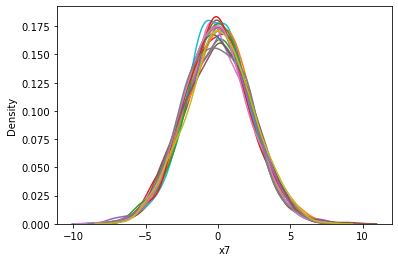

In [56]:
for i in range(1,20):
    sns.kdeplot(dfs[i]["x7"])
    

By using the path coefficients method we can estimate the true causal effect $E[X_7|\mathrm{do}(X_5=1)] - E[X_7|\mathrm{do}(X_5=0)] = 0.8^2 = 0.64$. 

We can now try to estimate the effect of $X_5$ on $X_7$ in a *naive way*, just by:
- regressing $X_7$ on $X_5$ with `LinearRegression` in `scikit-learn`
- extracting the linear coefficient of the trained model for $X_5$ 

We will repeat this estimation on all 2000 datasets and then check the mean and the standard deviation of the estimated coefficient. 

If the estimator is unbiased, the mean should be close to the true causal effect. We will also generally prefer an estimator with a lower variance.
In this case, we already know that this estimator will be biased, since $Z=\emptyset$ is not a valid adjustment set and we are not adjusting for any variable.

In [57]:
unadjusted_coeff = []

for i in range(1,n_datasets):
    df = dfs[i]
    linear_regressor = LinearRegression() 
    linear_regressor.fit(df["x5"].values.reshape(n_samples, 1), df["x7"].values.reshape(-1, 1))
    unadjusted_coeff.append(linear_regressor.coef_)
    
# Mean and variance of unadjusted estimation
print(np.mean(unadjusted_coeff), np.var(unadjusted_coeff))

0.9070061248088249 0.0008801089549571333


As expected the unadjusted regression gives a biased estimator. 

We will now try to adjust on a valid adjustment set, in this case the parent set of the treatment variable $X_5$, which are the variables $X_1$ and $X_2$, which should give us an unbiased estimator:

In [67]:
parents_coeff = []

for i in range(1,n_datasets):
    df = dfs[i]
    linear_regressor = LinearRegression() 
    # Using X_1, X_2 and X_5 as inputs to estimate X_7
    linear_regressor.fit(df.iloc[:, [0,1,4]].values.reshape(n_samples, 3), df["x7"].values.reshape(-1, 1))
    # Select only the coefficient of X_5
    parents_coeff.append(linear_regressor.coef_[:,2])
    
# Mean and variance of parents of treatment estimation (a valid adjustment set):
print(np.mean(parents_coeff), np.var(parents_coeff))

0.6403922180144807 0.002283680406296319


We will now try to adjust on another valid adjustment set, in this case $Z = \{X_2,X_3\}$ which should give us an unbiased estimator:

In [66]:
X2X3_coeff = []

for i in range(1,n_datasets):
    df = dfs[i]
    linear_regressor = LinearRegression() 
    # Using X_2, X_3 and X_5 as inputs to estimate X_7
    linear_regressor.fit(df.iloc[:, [1,2,4]].values.reshape(n_samples, 3), df["x7"].values.reshape(-1, 1))
    # Select only the coefficient of X_5
    X2X3_coeff.append(linear_regressor.coef_[:,2])
    
# Mean and variance of using X_2 and X_3 as adjustment (a valid adjustment set):
print(np.mean(X2X3_coeff), np.var(X2X3_coeff))

0.6409025200211056 0.0008113340957051437


We will now try to adjust on another valid adjustment set, in this case $Z = \{ X_2,X_3, X_4 \}$ which should give us an unbiased estimator:

In [68]:
X2X3X4_coeff = []

for i in range(1,n_datasets):
    df = dfs[i]
    linear_regressor = LinearRegression() 
    # Using X_2, X_3, X_4 and X_5 as inputs to estimate X_7
    linear_regressor.fit(df.iloc[:, 1:5].values.reshape(n_samples, 4), df["x7"].values.reshape(-1, 1))
    # Select only the coefficient of X_5
    X2X3X4_coeff.append(linear_regressor.coef_[:,3])
    
# Mean and variance of using X_2, X_3 and X_4 as adjustment (a valid adjustment set):
print(np.mean(X2X3X4_coeff), np.var(X2X3X4_coeff))

0.6410194783715331 0.002357885753100567


While all of these estimators with valid adjustement sets are all unbiased (the mean of the estimator across multiple datasets is close to the mean we can compute with the path method, 0.64), the variance varies across the different adjustment sets. We will not discuss how to choose the optimal adjustment set in the class, but if you are curious there is a recent method for linear models that show how to choose an optimal adjustment set [here](https://arxiv.org/abs/1907.02435) and an even more recent extension [here](https://arxiv.org/abs/2002.06825).